In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
import nltk
from nltk.corpus import stopwords

from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score

from sklearn.model_selection import GridSearchCV

# Данные

## Чтение

In [60]:
comments_msk = pd.read_csv('data/data_msk.csv', sep=',', decimal=",")
comments_msk = comments_msk.drop(columns = ['commentsLink', ' index'], axis=1)

comments_spb = pd.read_csv('data/data_spb.csv', sep=',', decimal=",")
comments_spb = comments_spb.drop(columns = ['commentsLink', ' index'], axis=1)

comments_ekt = pd.read_csv('data/data_ekt.csv', sep=',', decimal=",")
comments_ekt = comments_ekt.drop(columns = ['commentsLink', ' index'], axis=1)

comments_ksdr = pd.read_csv('data/data_ksdr.csv', sep=',', decimal=",")
comments_ksdr = comments_ksdr.drop(columns = ['commentsLink', ' index'], axis=1)

comments_kzn = pd.read_csv('data/data_kzn.csv', sep=',', decimal=",")
comments_kzn = comments_kzn.drop(columns = ['commentsLink', ' index'], axis=1)

comments_nnov = pd.read_csv('data/data_nnov.csv', sep=',', decimal=",")
comments_nnov = comments_nnov.drop(columns = ['commentsLink', ' index'], axis=1)

comments_rnd = pd.read_csv('data/data_rnd.csv', sep=',', decimal=",")
comments_rnd = comments_rnd.drop(columns = ['commentsLink', ' index'], axis=1)

In [61]:
comments = pd.concat([
    comments_msk,
    comments_spb,
    comments_ekt,
    comments_ksdr,
    comments_kzn,
    comments_nnov,
    comments_rnd
    ], axis=0)
comments

,comment,mark
0,Преподаватель находит индивидуальный подход п...,Оценка: 5+.
1,Плюсы: Анна Валерьевна обязательна компетентн...,Оценка: 5.
2,СПАСИБО Анна Валерьевна! Сдали хорошо ЕГЭ. С ...,Оценка: 5.
3,50 % успеха - наличие контакта с преподавател...,Оценка: 5+.
4,Анна Валерьевна является не только уникальным...,Оценка: 5+.
...,...,...
7223,С Марией Николаевной мы занимаемся не так час...,Оценка: 5.
7224,Хорошо. Она хорошо преподает. Понятно доступ...,Оценка: 5.
7225,В принципе все положительно. Замечательный п...,Оценка: 5.
7226,Мы занимаемся до сих пор. Впечатления положит...,Оценка: 5.


## Разбиение на классы

In [62]:
comments = comments.reset_index(drop=True)

In [63]:
comments.rename(columns = {' comment' : 'comment', ' mark' : 'mark'}, inplace = True )

In [64]:
np.unique(comments['mark'])

array([' Оценка: 1.', ' Оценка: 2.', ' Оценка: 3+.', ' Оценка: 3.',
       ' Оценка: 3−.', ' Оценка: 4+.', ' Оценка: 4.', ' Оценка: 4−.',
       ' Оценка: 5+.', ' Оценка: 5.', ' Оценка: 5−.'], dtype=object)

In [65]:
comments.groupby('mark').nunique()

,comment
mark,
Оценка: 1.,180
Оценка: 2.,601
Оценка: 3+.,152
Оценка: 3.,969
Оценка: 3−.,182
Оценка: 4+.,1446
Оценка: 4.,3195
Оценка: 4−.,441
Оценка: 5+.,56243


Так как классов слишком много и они очень несбалансированные, объединим их в группы классов - 2,3,4,5 следующим образом:

In [66]:
comments.loc[(comments['mark'] == ' Оценка: 5.'), 'mark'] = 5
comments.loc[(comments['mark'] == ' Оценка: 5+.'), 'mark'] = 5

comments.loc[(comments['mark'] == ' Оценка: 5−.'), 'mark'] = 4
comments.loc[(comments['mark'] == ' Оценка: 4.'), 'mark'] = 4
comments.loc[(comments['mark'] == ' Оценка: 4+.'), 'mark'] = 4

comments.loc[(comments['mark'] == ' Оценка: 4−.'), 'mark'] = 3
comments.loc[(comments['mark'] == ' Оценка: 3.'), 'mark'] = 3
comments.loc[(comments['mark'] == ' Оценка: 3+.'), 'mark'] = 3

comments.loc[(comments['mark'] == ' Оценка: 3−.'), 'mark'] = 2
comments.loc[(comments['mark'] == ' Оценка: 2.'), 'mark'] = 2
comments.loc[(comments['mark'] == ' Оценка: 1.'), 'mark'] = 2

Примеры отзывов с оценкой 5 и 2:

In [67]:
for i in comments.loc[(comments['mark'] == 5), 'comment'][:5]:
    print(i, '\n')

 Преподаватель находит индивидуальный подход процесс обучения проходил отлично поставленной задачи достигли. 

 Плюсы: Анна Валерьевна обязательна компетентна внимательна и хорошо нашла общий язык с моим сыном. Описание: Результатом занятий моего сына стало поступление в один из физико-математических лицеев куда мы планировали. Не смотря на то что мы поздно взялись готовиться и сын занимался всего месяц. И честно говоря я допускала что они не успеют освоить необходимый материал. Я очень благодарна Анне Валерьевне что она нам помогла. 

 СПАСИБО Анна Валерьевна! Сдали хорошо ЕГЭ. С детьми на одной волне(слова сына). С родителями всегда на связи. Спасибо за занятия знания и поддержку. Рекомендуем!!! 

 50 % успеха - наличие контакта с преподавателем его желание работать с самыми разными уровнями подготовки и проблемами ученика не просто готовить к экзамену хороших ребят которые мотивированы и им необходимо помочь "поднатаскать" к сдаче а именно разбираться с проблемой не только на уровне

In [68]:
for i in comments.loc[(comments['mark'] == 2), 'comment'][:5]:
    print(i, '\n')

 Постоянно отвлекаеться на смс в телефоне  не корректно объясняет ту или инную тему на разбор заданий недостаточно уделяет время. 

 Репетитор не понравился т. к. все 90 минут он смотрел в телефон или писал смс. Никакой заинтересованности в работе не проявил. Точно не наш вариант. 

 Плюсы: Дистанционное обучение на сайте Невысокая цена обучения Минусы: Слишком много лишней информации в уроках Поменял основной язык программирования Решение большого количества задач в ручном режиме Описание: Я купил курс по информатике летом 2020 года (за 2 года до ЕГЭ). Прозанимавшись год на языке С++ в сентябре 2021 года Максим Юрьевич поменял его на Питон. Сейчас я понимаю что питон больше подходит для ЕГЭ. Но в результате год обучения потерян представляете! Слишком много времени было посвящено решению задач в ручном режиме как показала практика на ЕГЭ большинство задач нужно решать в программном режиме что гораздо быстрее и повышает точность результатов. В результате такого подхода мне не хватило вр

## Балансировка

Случайно выберем и удалим большую часть данных с оценкой 5 для сбалансированности:

In [69]:
comments = comments.sort_values(by = ['mark'])[:-110000]

In [70]:
comments.groupby('mark').nunique()

,comment
mark,
2,963
3,1562
4,5976
5,14080


In [71]:
comments = shuffle(comments)
comments

,comment,mark
94115,Плюсы: Новатор умница! Минусы: Нет Описание:...,5
81289,Профессиональный педагог знающий ответственны...,4
90671,Плюсы: Вера Петровна сразу принялась к делу ...,5
86911,Мне понравился репетитор по рисованию Федор А...,5
90290,Оксана Константиновна - доброжелательный чело...,4
...,...,...
30369,Всё хорошо. Нас всё устраивает мы довольны. П...,4
7604,Репетитор самого начального уровня. Серьезнос...,3
92205,Спасибо сайту и репетитору Юлии Александровне,5
88487,Провели 6-7 занятий. Дочери были непонятны об...,3


<AxesSubplot: xlabel='mark', ylabel='count'>

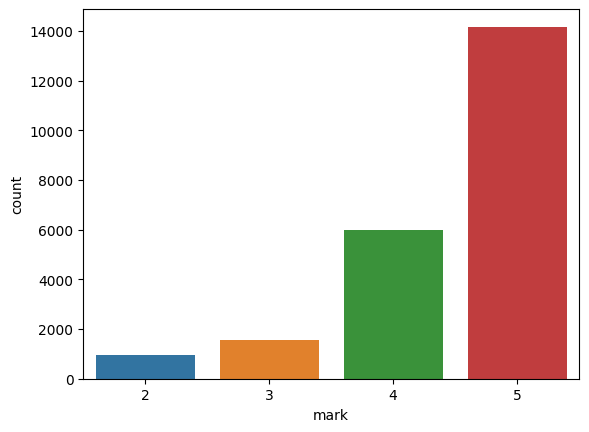

In [72]:
sns.countplot(x = comments['mark'],data = comments)

Видим, что есть очень большие по длине отзывы, учтем это при анализе:

<AxesSubplot: ylabel='Count'>

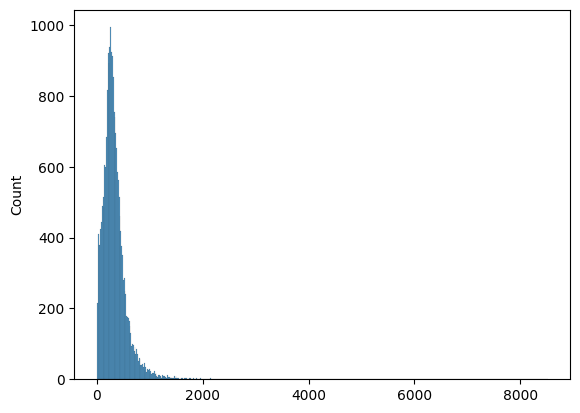

In [73]:
sns.histplot([len(comment) for comment in comments['comment']])

In [74]:
comments['mark'] = comments['mark'].astype(str).astype(int)
comments['comment'] = comments['comment'].astype(str)

# Prepocessing

In [75]:
# !pip3 install WordCloud

Загрузим русский список стоп-слов и удалим из него слова "не" и "нет", так как они часто встречаются в отрицательных отзывах и редко в положительных, значит могут быть полезными при классификации:

In [76]:
nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")
stopwords_ru.remove('не')
stopwords_ru.remove('нет')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natalaantonenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Создадим функцию preprocessing, с помощью которой будем предобрабатывать наши отзывы, а именно: 
1. разбивать на токены
2. приводить к нормальной форме
3. удалять стоп-слов

In [77]:
patterns = "[A-Za-z!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
morph = MorphAnalyzer()
stop_repetit_words = ['репетитор', 'занятие', 'преподаватель', 'педагог', 'ребёнок']

def preprocessing(doc):
    doc = re.sub(patterns, ' ', doc)
    string = ''
    for token in doc.split():
        if token:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            if token not in stopwords_ru and token not in stop_repetit_words:
                string += token + ' '
    if len(string.split()) > 7:
        return string
    return None

In [78]:
data = comments.iloc[:,0].apply(preprocessing)

In [79]:
comments['comm_tokens'] = data
comments = comments.dropna()
len(comments)

20884

In [80]:
comments['comm_tokens'] = comments['comm_tokens'].astype(str)

/var/folders/0b/7m67yr996xq16ssxkwly78q80000gr/T/ipykernel_17796/269570169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments['comm_tokens'] = comments['comm_tokens'].astype(str)


In [81]:
comments

,comment,mark,comm_tokens
94115,Плюсы: Новатор умница! Минусы: Нет Описание:...,5,плюс новатор умница минус нет описание спасибо...
81289,Профессиональный педагог знающий ответственны...,4,профессиональный знающий ответственный пунктуа...
90671,Плюсы: Вера Петровна сразу принялась к делу ...,5,плюс вера петрович сразу приняться дело провод...
86911,Мне понравился репетитор по рисованию Федор А...,5,понравиться рисование фёдор александрович знат...
90290,Оксана Константиновна - доброжелательный чело...,4,оксана константинович доброжелательный человек...
...,...,...,...
51679,А вот на фоне всех положительных отзывов у мо...,2,фон весь положительный отзыв дочь валентина ни...
30369,Всё хорошо. Нас всё устраивает мы довольны. П...,4,всё всё устраивать довольный продолжать занима...
7604,Репетитор самого начального уровня. Серьезнос...,3,начальный уровень серьёзность намерение обучен...
88487,Провели 6-7 занятий. Дочери были непонятны об...,3,провести 6 7 дочь непонятный объяснение татьян...


# Обучение

In [82]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(comments['comm_tokens'])
y = comments['mark']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 1234)

In [83]:
X_train.shape, X_test.shape

((14618, 15726), (6266, 15726))

Строим 6 классификаторов и для каждого выводим значения precision, recall, f1_score:

In [84]:
def model_score(model, criterion):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return criterion(y_pred, y_test, average='weighted')

models_name = ['LogisticRegression', 'RandomForestClassifier', 'ComplementNB',
               'DecisionTreeClassifier', 'GradientBoostingClassifier', 
               'AdaBoostClassifier']
models = [LogisticRegression(solver='lbfgs', max_iter=1000), RandomForestClassifier(), ComplementNB(),
          DecisionTreeClassifier(), GradientBoostingClassifier(), 
          AdaBoostClassifier()]
model_result = {}

quality = [precision_score, 
           recall_score, 
           f1_score]
        
for i in range(len(models)):
    model_result[models_name[i]] = [model_score(models[i],q) for q in quality]
        
pd.DataFrame(model_result, index = ['precision', 'recall', 'f1_weighted'])

,LogisticRegression,RandomForestClassifier,ComplementNB,DecisionTreeClassifier,GradientBoostingClassifier,AdaBoostClassifier
precision,0.807190,0.861339,0.843585,0.638494,0.805183,0.773722
recall,0.757581,0.703958,0.709384,0.623683,0.722630,0.686403
f1_weighted,0.775360,0.759941,0.755959,0.635803,0.752644,0.718086


Лучше всего справились модели RandomForestClassifier и ComplementNB
Построим одну из них отдельно и посмотрим результат:

In [85]:
best_model = ComplementNB()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


y_test_index = y_test.index.tolist()
d = {'x_test': comments.loc[y_test_index].comment.values, 'y_test': y_test, 'y_pred': y_pred}
df_ComplementNB = pd.DataFrame(d)

In [86]:
accuracy_score(y_pred,y_test)

0.7093839770188318

In [87]:
df_ComplementNB[:50].sort_values(by = ['y_test'])

,x_test,y_test,y_pred
101479,Преподаватель после оставленного положительно...,2,2
97568,Плюсы: для нас плюс занятия по скайпу Минусы:...,2,2
45667,Лично для меня преподаватель был некорректный...,2,2
247,Создается впечатление что на сайте публикуютс...,3,4
70990,Светлана Борисовна использовала не совсем тот...,3,4
15653,Как педагог хорошо обучает она со вторым ребе...,4,4
70964,Александра Александровна – молодой репетир от...,4,4
76310,Альбина Фаритовна - неплохой педагог. Человек...,4,4
86358,В процессе обучения Марина Викторовна не толь...,4,5
83396,Так получилось что мы недолго занимались с Ар...,4,5


Выведем строки, где y_test отличается от y_pred больше, чем на 2 и рассмотрим несколько примеров:

In [88]:
df_ComplementNB.loc[(df_ComplementNB['y_test'] - df_ComplementNB['y_pred']) > 1][:10]

,x_test,y_test,y_pred
94552,То что так долго искала! Качество уборки устр...,5,2
97793,Плюсы: + Описание: Проводит занятия интересно...,5,3
92804,Не знаю много-ли таких же бесперспективных у...,5,2
112674,Убралась не так как я хотела. Плинтуса не пр...,4,2
51976,Елена Дмитриевна грамотный репетитор бразильс...,4,2
90844,Мы сдали на четвёрку. Результатом довольны. А...,5,2
59994,Ребёнку понравилось . К сожалению родители к ...,4,2
94863,Плюсы: Хороший репетитор Описание: 2 занятия ...,5,2
92179,Профи своего дела. Очень помогла с медиаплани...,5,2
40556,Как преподаватель по английскому языку Карл х...,4,2


In [89]:
df_ComplementNB.x_test[95129]

KeyError: 95129

In [ ]:
df_ComplementNB.x_test[98512]

В обоих примерах модель предсказывала оценки ниже истинных. Возможно повлияли такие слова, как: "тяжелый", "мучает", "ошибрк", "заминок". Теперь посмотрим примеры, когда модель предсказывает оценки выше истинных:

In [ ]:
df_ComplementNB.loc[(df_ComplementNB['y_pred'] - df_ComplementNB['y_test']) > 1][:10]

Есть отзывы с сарказмом, что модели сложно оценить:

In [ ]:
df_ComplementNB.x_test[107561]

В случае второго отзыва, точно повлияли слова: "пунктуальность", "хорошего":

In [ ]:
df_ComplementNB.x_test[41501]

Посмотрим на accuacy классификатора RandomForestClassifier:

In [ ]:
best_model = RandomForestClassifier()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


y_test_index = y_test.index.tolist()
d = {'x_test': comments.loc[y_test_index].comment.values, 'y_test': y_test, 'y_pred': y_pred}
df_RandomForestClassifier = pd.DataFrame(d)

In [ ]:
accuracy_score(y_pred,y_test)

## GridSearchCV

In [ ]:
params = [
    {
        'C' : [0.5, 1.0, 5.0], 
        'tol' : [1e-4, 1e-5]
    }, {  
        'n_estimators': [20, 40, 50],
        'max_depth': [4, 5, 6],
        'max_features': [3, 5, 10],
        'min_samples_split': [3, 5, 10, 15],
    }, {
        'alpha' : [0.01, 0.1, 1.0, 2.0, 5.0]
    }
]

In [ ]:
def model_best_params_score(model, criterion, params):
    grid_CV_1 = GridSearchCV(model, param_grid = params, cv=2, scoring='f1-score')
    grid_CV_1.fit(X_train, y_train)
    best_model = grid_CV_1.best_estimator_
    y_pred = best_model.predict(X_test) 
    return criterion(y_pred, y_test, average='weighted', zero_division=0), grid_CV_1.best_params_

model_best_params = {}

for i in range(3):
    model_best_params[models_name[i]] = [model_best_params_score(models[i],precision_score,params[i])[0],
                                         model_best_params_score(models[i],recall_score,params[i])[0],
                                         model_best_params_score(models[i],f1_score,params[i])[0],
                                         model_best_params_score(models[i],f1_score,params[i])[1]]
    
models_best_params = pd.DataFrame(model_best_params, index = ['precision', 'recall', 'f1_weighted','best_params'])

In [ ]:
models_best_params

In [ ]:
models_best_params[3:].values

In [ ]:
best_model = RandomForestClassifier(max_depth=4, max_features=3, min_samples_split=3, n_estimators=20)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

y_test_index = y_test.index.tolist()
d = {'x_test': comments.loc[y_test_index].comment.values, 'y_test': y_test, 'y_pred': y_pred}
df_RandomForestC = pd.DataFrame(d)

In [ ]:
df_RandomForestC.loc[df_RandomForestC['y_pred'] != 5]

Значение precision у RandomForestClassifier = 1.0, потому что модель предсказала для всех данных значение 5, что можно было предполагать, учитывая небольшой дисбаланс.

С гридом, на удивление, модели построились не такими качественными, как с дефолтными параметрами. Лучшими остаеюся модели ComplementNB и RandomForestClassifier с дефолтными значениями.